# Lorenz system as described in Brunton et al.

A true Lorenz system is a simplified mathematical model for atmospheric convection, and is defined as the following system of ODEs:

$\dot{x} = \sigma(y-x)$ 

$\dot{y} = x(\rho - z) - y$

$\dot{z} = xy - \beta z$

Let us assume the following common parameter values: 
$\sigma = 10, \beta = 8/3, \rho = 28$

We're going to explore different regression methods that can be employed to estimate the parameters $\sigma, \beta,$ and $\rho$ from synthetic Lorenz system data. 

## Data generation

Let's start out by generating the synthetic data we want to use. We're going to accomplish this by solving the ODE using a fourth order Runge-Kutta ODE solver with the assumed parameter values and 10,000 time increments. The $x$, $y$, and $z$ values we get from this represent our synthetic data. 

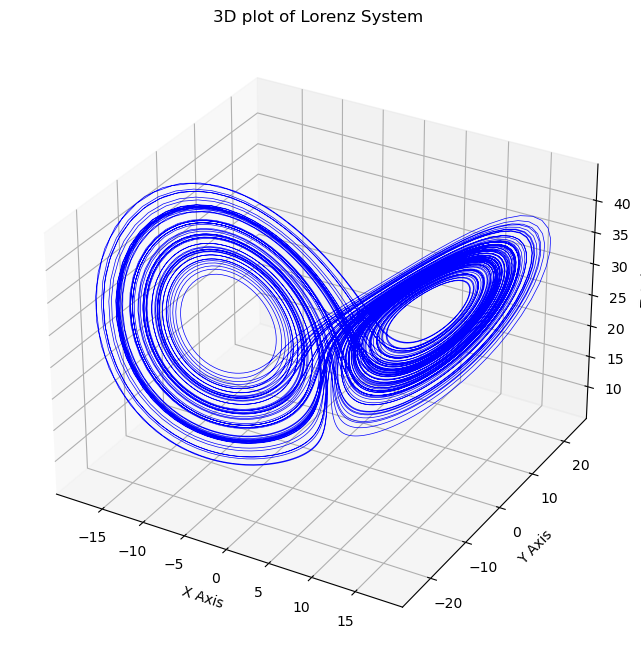

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Define the Lorenz system
def lorenz(t, state, sigma, rho, beta):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return np.array([dxdt, dydt, dzdt])

# Implement RK4 method
def rk4(func, y0, t, args=()):
    dt = t[1] - t[0]
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for i in range(1, len(t)):
        k1 = func(t[i-1], y[i-1], *args)
        k2 = func(t[i-1] + dt/2, y[i-1] + dt*k1/2, *args)
        k3 = func(t[i-1] + dt/2, y[i-1] + dt*k2/2, *args)
        k4 = func(t[i-1] + dt, y[i-1] + dt*k3, *args)
        y[i] = y[i-1] + dt*(k1 + 2*k2 + 2*k3 + k4)/6
    return y

# Parameters for the Lorenz system
sigma = 10
rho = 28
beta = 8/3

# Initial conditions and time array
y0 = [-8, 8, 27]
t = np.linspace(0, 100, 10000)

# Solve the Lorenz system using RK4
solution = rk4(lorenz, y0, t, args=(sigma, rho, beta))

# Create a 3D plot of the Lorenz system data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(solution[:, 0], solution[:, 1], solution[:, 2], lw=0.5, color="blue")
ax.set_title('3D plot of Lorenz System')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

plt.show()


## 5th order basis functions

Let us consider the dynamical system whose equations take the following form: 
$$\dot{X} = \Theta(X)\Xi$$

$\dot{X}$ is defined to be the derivatives of our system. We can compute these exactly by plugging in our synthetic data back into our system of differential equations, or numerically through a finite difference method for example. 

$\Theta(X)$ is what we call our library. Each column represents a candidate function, or basis function, for the state of our system through all time points. In this case, we are going to create a library of candidate funcitons that go up to the fifth order. This means our library will look like $1, x, y, z, x^2, xy, xz, y^2, yz, z^2, \dots$. 

Each column of $\Xi$ represents each equation in our system. The rows correspond to the basis functions in our library. This means each entry tells us the coefficient corresponding to each basis function in our system of equations. 

With these three matricies, we can apply the method of least squares to solve for $\Xi$:
$$
\xi =  \arg\min_{\xi} \left\| x - \Theta \xi \right\|_2^2
$$

This representation of a dynamical system is described in the paper by Dr. Steven Brunton and his collegues, "[Discovering governing equations from data by sparse identification of nonlinear dynamical systems](https://www.pnas.org/doi/10.1073/pnas.1517384113)." This method allows us to discover the sparsest system of governing equations for any non-linear system. Figure 1 from this paper clearly depicts how this method can be used to estimate the parameters of the Lorenz system: 

![fig 1](SINDy_Lorenz.png)

The goal of this code is to recreate the results depicted in this figure. 

The code below is from [this blog post](https://bea.stollnitz.com/blog/sindy-lorenz/) and creates our fifth order library. 

In [3]:
# Function to create library 
def create_library(u: np.ndarray, polynomial_order: int,
                   use_trig: bool) -> np.ndarray:
    """Creates a matrix containing a library of candidate functions.

    For example, if our u depends on x, y, and z, and we specify
    polynomial_order=2 and use_trig=false, our terms would be:
    1, x, y, z, x^2, xy, xz, y^2, yz, z^2.
    """
    (m, n) = u.shape
    theta = np.ones((m, 1))

    # Polynomials of order 1.
    theta = np.hstack((theta, u))

    # Polynomials of order 2.
    if polynomial_order >= 2:
        for i in range(n):
            for j in range(i, n):
                theta = np.hstack((theta, u[:, i:i + 1] * u[:, j:j + 1]))

    # Polynomials of order 3.
    if polynomial_order >= 3:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    theta = np.hstack(
                        (theta, u[:, i:i + 1] * u[:, j:j + 1] * u[:, k:k + 1]))

    # Polynomials of order 4.
    if polynomial_order >= 4:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for l in range(k, n):
                        theta = np.hstack(
                            (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                             u[:, k:k + 1] * u[:, l:l + 1]))

    # Polynomials of order 5.
    if polynomial_order >= 5:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for l in range(k, n):
                        for m in range(l, n):
                            theta = np.hstack(
                                (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                                 u[:, k:k + 1] * u[:, l:l + 1] * u[:, m:m + 1]))

    if use_trig:
        for i in range(1, 11):
            theta = np.hstack((theta, np.sin(i * u), np.cos(i * u)))

    return theta


# Now, let's generate the Theta matrix with basis functions up to order 5
Theta = create_library(solution, 5, False)


## $\dot{x}$, $\dot{y}$, $\dot{z}$ computed with exact derivatives 

The cell below computes $\dot{X}$ by inputting the solution to our data back into the known governing equations. It is important to note that this case is not very realistic because we ususally don't know the equations that describe our dynamical system. 

In [4]:
X_dot = np.array([lorenz(None, state, sigma, rho, beta) for state in solution])

## $\dot{x}$, $\dot{y}$, $\dot{z}$ computed with finite differences

The code below is a central finite difference algorithm which is used to calculate $\dot{X}$. 

In [5]:
def finite_difference(data, dt):
    # Initialize an empty array for the derivatives
    derivatives = np.zeros_like(data)
    
    # Forward difference for the first data point
    derivatives[0] = (data[1] - data[0]) / dt
    
    # Central difference for the intermediate data points
    for i in range(1, len(data) - 1):
        derivatives[i] = (data[i+1] - data[i-1]) / (2 * dt)
    
    # Backward difference for the last data point
    derivatives[-1] = (data[-1] - data[-2]) / dt
    
    return derivatives

X_dot_fd = finite_difference(solution, t[1] - t[0])

## Ordinary least squares (OLS) $\dot{x}$, $\dot{y}$, $\dot{z}$ with exact derivatives

In [12]:
# Ordinary least squares
Xi_exact_built, _, _, _ = np.linalg.lstsq(Theta, X_dot, rcond=None)

# Display result
Xi_exact_built

array([[-2.97173462e-08,  1.48633504e-07,  5.88392395e-10],
       [-1.00000000e+01,  2.80000000e+01,  1.69459909e-09],
       [ 1.00000000e+01, -9.99999997e-01, -7.49851746e-10],
       [ 1.75597666e-09, -1.32717579e-08, -2.66666667e+00],
       [-2.51747687e-10, -9.64830691e-10,  4.08136949e-11],
       [ 7.16940385e-10, -1.03048912e-09,  1.00000000e+00],
       [ 8.48526328e-10, -1.00000000e+00, -1.19389061e-10],
       [-1.23304704e-10,  5.08721167e-10,  4.86986108e-11],
       [-4.08673479e-10, -1.70603924e-10,  4.57680135e-11],
       [ 3.67799555e-11,  2.66775547e-10, -1.05718595e-11],
       [-4.02285643e-11,  2.57018810e-11, -3.18750240e-12],
       [ 2.86518494e-11,  1.81866471e-13, -1.55486333e-12],
       [-4.40150548e-11,  1.05323512e-10,  1.46463245e-12],
       [-2.85095212e-12, -3.99167491e-11,  3.35217813e-12],
       [ 1.75657845e-11,  1.75757109e-12,  1.95320756e-13],
       [-1.29746056e-11, -5.43508760e-13,  3.98220237e-12],
       [-6.70467561e-13,  1.68844381e-11

## OLS $\dot{x}$, $\dot{y}$, $\dot{z}$ via finite differences

In [7]:
Xi_fd_manual = np.linalg.inv(Theta.T @ Theta) @ Theta.T @ X_dot_fd
Xi_fd_built, _, _, _ = np.linalg.lstsq(Theta, X_dot_fd, rcond=None)

# Compare matrices: 
print('Result from np.allclose: ' + str(np.allclose(Xi_fd_manual, Xi_fd_built)))

# Format Xi based on Xi_built_order5, since both of the matrices are almost equivalent 
Xi_formatted = np.array([[f"{value:.6f}" for value in row] for row in Xi_fd_built])

# Display results 
Xi_formatted

Result from np.allclose: False


array([['-0.904000', '-0.296647', '0.995664'],
       ['-6.286588', '30.716409', '-3.598874'],
       ['8.164293', '-2.310735', '1.788775'],
       ['0.352852', '0.094071', '-3.066104'],
       ['-0.179099', '-0.120891', '0.151325'],
       ['0.212227', '0.142310', '0.822865'],
       ['-0.734795', '-1.510037', '0.690273'],
       ['-0.061668', '-0.040012', '0.055716'],
       ['0.361375', '0.246498', '-0.339722'],
       ['-0.052862', '-0.011256', '0.061164'],
       ['-0.054159', '-0.027716', '0.055080'],
       ['0.077572', '0.025068', '-0.086126'],
       ['-0.010215', '0.000251', '0.013612'],
       ['-0.037264', '-0.002826', '0.045833'],
       ['0.010778', '0.001397', '-0.013584'],
       ['0.053733', '0.037042', '-0.049885'],
       ['0.005837', '-0.001521', '-0.008090'],
       ['-0.002855', '-0.000961', '0.003135'],
       ['-0.026602', '-0.018178', '0.024735'],
       ['0.003860', '0.000662', '-0.004544'],
       ['-0.001937', '-0.000724', '0.002091'],
       ['0.001347', '0

## Observations

We can see that performing ordinary least squares while using exact derivatives gives us the results we want (can be seen in the figure from Brunton et al.), though it is a little messy with values that are basically 0. However, ordinary least squares fails to estimate the parameters when we use finite differences. We need to apply a new regression technique to fix this. 

## Define sequential threshold least squares (STLS)

Sequential Threshold Least Squares (STLS) is a method used to fit a model to data when you have a lot of potential predictors, but only some of them might be useful. In STLS, you start by fitting the model with all the predictors. After this, the least important predictors (those with the smallest effect) are removed one by one, based on certain threshold criteria, until you're left with only the most significant predictors. This results in a more simplified model that focuses on the most influential variables.

In [8]:
# Function to perform SLS with a maximum number of iterations
def perform_SLS(Theta, xi_original, target, threshold, max_iter):
    # Initialize xi and iteration count
    xi = xi_original.copy()
    iter_count = 0
    while iter_count < max_iter:
        # Find small indices and update xi
        small_indices = np.abs(xi) < threshold
        # Break if no small indices are found
        if np.all(small_indices == False):
            break
        xi[small_indices] = 0
        # Updating xi with normal equation
        new_Theta = Theta[:, ~small_indices]
        updated_values = np.linalg.inv(new_Theta.T @ new_Theta) @ new_Theta.T @ target
        # Update xi with new values
        xi[~small_indices] = updated_values
        iter_count += 1
    return xi

## SLS with exact $\dot{x}$, $\dot{y}$, $\dot{z}$

In [9]:
# Define 
threshold = 0.05
max_iter = 100

# Perform SLS with exact derivitaves 
Xi_sls_exact_x = perform_SLS(Theta, Xi_exact_built[:, 0], X_dot[:, 0], threshold, max_iter)
Xi_sls_exact_y = perform_SLS(Theta, Xi_exact_built[:, 1], X_dot[:, 1], threshold, max_iter)
Xi_sls_exact_z = perform_SLS(Theta, Xi_exact_built[:, 2], X_dot[:, 2], threshold, max_iter)

Xi_sls_exact = np.column_stack((Xi_sls_exact_x, Xi_sls_exact_y, Xi_sls_exact_z))

Xi_sls_exact

array([[  0.        ,   0.        ,   0.        ],
       [-10.        ,  28.        ,   0.        ],
       [ 10.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,  -2.66666667],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ],
       [  0.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.     

## SLS with $\dot{x}$, $\dot{y}$, $\dot{z}$ via finite differences

In [10]:
# Define 
threshold = 0.05
max_iter = 100

# Perform SLS with exact derivitaves 
Xi_sls_fd_x = perform_SLS(Theta, Xi_fd_built[:, 0], X_dot[:, 0], threshold, max_iter)
Xi_sls_fd_y = perform_SLS(Theta, Xi_fd_built[:, 1], X_dot[:, 1], threshold, max_iter)
Xi_sls_fd_z = perform_SLS(Theta, Xi_fd_built[:, 2], X_dot[:, 2], threshold, max_iter)

Xi_sls_fd = np.column_stack((Xi_sls_fd_x, Xi_sls_fd_y, Xi_sls_fd_z))

Xi_sls_fd

array([[  0.        ,   0.        ,   0.        ],
       [-10.        ,  28.        ,   0.        ],
       [ 10.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,  -2.66666667],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ],
       [  0.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.     

## Observations 

Here we can see we have the final $\Xi$ matricies are exactly how we want them. STLS cleans up the values in the exact derivative case, and gives us the coefficients we want with the finite difference case. 